# Expedia Hotel Recommender System- DeepFM

## Importing all libraries

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import warnings
import math
from math import sqrt

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense

import sys
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import add_func

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

# Reading and Storing Data

In [193]:
df = pd.read_csv("..\data\\train.csv", sep=',', nrows=150000)
df.shape

(150000, 24)

In [194]:
df.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 25 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_time                  150000 non-null  object 
 1   site_name                  150000 non-null  int64  
 2   posa_continent             150000 non-null  int64  
 3   user_location_country      150000 non-null  int64  
 4   user_location_region       150000 non-null  int64  
 5   user_location_city         150000 non-null  int64  
 6   orig_destination_distance  97558 non-null   float64
 7   user_id                    150000 non-null  int64  
 8   is_mobile                  150000 non-null  int64  
 9   is_package                 150000 non-null  int64  
 10  channel                    150000 non-null  int64  
 11  srch_ci                    149875 non-null  object 
 12  srch_co                    149875 non-null  object 
 13  srch_adults_cnt            15

In [196]:
df['click_month'] = pd.DatetimeIndex(df['date_time']).month

In [198]:
df= df.drop(['date_time'],axis=1)
df= df.drop(['orig_destination_distance'],axis=1)

In [74]:
# extract month from date_time
df['checkin_month'] = pd.DatetimeIndex(df['srch_ci']).month
df['checkout_month'] = pd.DatetimeIndex(df['srch_co']).month
df['click_month'] = pd.DatetimeIndex(df['date_time']).month

In [75]:
df= df.drop(['date_time'],axis=1)
df= df.drop(['srch_ci'],axis=1)
df= df.drop(['srch_co'],axis=1)
df= df.drop(['orig_destination_distance'],axis=1)

In [199]:
# rename columns
df = df.rename(columns={'hotel_cluster': 'item_id', 'is_booking': 'rating'})

### Sparse Features/ Categorical features

In [77]:
# categ_sparse 
sparse_features = ['site_name','posa_continent','user_location_country','user_location_region','user_location_city',
             'user_id','is_mobile','is_package','channel','click_month','checkin_month','checkout_month',
            'srch_adults_cnt','srch_children_cnt','srch_rm_cnt','srch_destination_id','hotel_continent',
               'hotel_country','cnt','click_month', 'checkin_month','checkout_month']

In [205]:
# categ_sparse 
sparse_features = ['site_name','posa_continent','user_location_country','user_location_region','user_location_city',
             'user_id','is_mobile','is_package','channel','click_month','srch_ci','srch_co',
            'srch_adults_cnt','srch_children_cnt','srch_rm_cnt','srch_destination_id','hotel_continent',
               'hotel_country','cnt','click_month']

### Dense Features/ Continuous Features

In [206]:
dense_features = ['hotel_market']

### Target Features

In [207]:
target = ['rating']

## Simple preprocessing

Usually we have two methods to encode the sparse categorical feature for embedding

**Label Encoding: map the features to integer value from 0 ~ len(#unique) - 1 

In [208]:
# Label Encoding for sparse features,and normalization for dense numerical features
for feat in sparse_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

### Here we use normalization

In [209]:
mms = MinMaxScaler(feature_range=(0,1))
df[dense_features] = mms.fit_transform(df[dense_features])

## Generate feature columns

For sparse features, we transform them into dense vectors by embedding techniques. For dense numerical features, we concatenate them to the input tensors of fully connected layer.

**Label Encoding and Generate feature columns

In [210]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=df[feat].nunique(),embedding_dim=4)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

## Generate the training samples and train the model

In [211]:
train, test = train_test_split(df, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

## Define Model and train the model

In [212]:
model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
model.compile("adam", "binary_crossentropy",metrics=['binary_crossentropy'])

In [213]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Epoch 1/10
375/375 - 4s - loss: 0.2711 - binary_crossentropy: 0.2706 - val_loss: 0.2428 - val_binary_crossentropy: 0.2418
Epoch 2/10
375/375 - 2s - loss: 0.2214 - binary_crossentropy: 0.2199 - val_loss: 0.2533 - val_binary_crossentropy: 0.2512
Epoch 3/10
375/375 - 2s - loss: 0.2071 - binary_crossentropy: 0.2045 - val_loss: 0.2715 - val_binary_crossentropy: 0.2684
Epoch 4/10
375/375 - 2s - loss: 0.1976 - binary_crossentropy: 0.1942 - val_loss: 0.2788 - val_binary_crossentropy: 0.2750
Epoch 5/10
375/375 - 2s - loss: 0.1905 - binary_crossentropy: 0.1865 - val_loss: 0.2993 - val_binary_crossentropy: 0.2950
Epoch 6/10
375/375 - 2s - loss: 0.1841 - binary_crossentropy: 0.1795 - val_loss: 0.3224 - val_binary_crossentropy: 0.3175
Epoch 7/10
375/375 - 3s - loss: 0.1776 - binary_crossentropy: 0.1726 - val_loss: 0.3396 - val_binary_crossentropy: 0.3344
Epoch 8/10
375/375 - 2s - loss: 0.1713 - binary_crossentropy: 0.1661 - val_loss: 0.3545 - val_binary_crossentropy: 0.3491
Epoch 9/10
375/375 - 2s 

In [214]:
#model prediction
pred_result = model.predict(test_model_input, batch_size=256)

In [215]:
auc = roc_auc_score(test[target].values, pred_result)

print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),"MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_result),2),"AUC:\t%f" % np.round(auc,2),sep='\n')

RMSE:	0.300000
MAE:	0.150000
MSE:	0.090000
AUC:	0.710000


## Let's Experiments on Hyper-parameters tuning and see their effect on model 

### Instantiates the DeepFM Network architecture.

#### Parameters:	

linear_feature_columns – An iterable containing all the features used by linear part of the model.

dnn_feature_columns – An iterable containing all the features used by deep part of the model.

fm_group – list, group_name of features that will be used to do feature interactions.

dnn_hidden_units – list,list of positive integer or empty list, the layer number and units in each layer of DNN

l2_reg_linear – float. L2 regularizer strength applied to linear part

l2_reg_embedding – float. L2 regularizer strength applied to embedding vector

l2_reg_dnn – float. L2 regularizer strength applied to DNN

seed – integer ,to use as random seed.

dnn_dropout – float in [0,1), the probability we will drop out a given DNN coordinate.

dnn_activation – Activation function to use in DNN

dnn_use_bn – bool. Whether use BatchNormalization before activation or not in DNN

task – str, "binary" for binary logloss or "regression" for regression loss

### Tuning Hyperparameters with GridSearchCV

Grid search, which is an optimization scheme trying all possible combinations of specified hyperparameter choices.

In [140]:
param_grid = {'dnn_hidden_units' : [(1,1),(2,2),(4,4),(27,27),(128,128),(256,256)],
              'dnn_use_bn':[True,False],
              'l2_reg_linear':[1e-5,1e-3,1e-1,1,10],
              'l2_reg_embedding':[1e-7,1e-5,1e-3,1e-1,1],
              'l2_reg_dnn':[0,0.2,2,4],
              'dnn_dropout':[0, 0.1, 0.3, 0.7, 0.9,0.11]
             }
result = {}

### dnn_hidden_units – list,list of positive integer or empty list, the layer number and units in each layer of DNN

In [105]:
dnn_hidden_units_layer = {}
for x in param_grid['dnn_hidden_units']:
    model = DeepFM(linear_feature_columns,dnn_feature_columns,fm_group=['default_group'], dnn_hidden_units=x, 
              seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    dnn_hidden_units_layer[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,2)}
result['dnn_hidden_units']=dnn_hidden_units_layer

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0883 - mse: 0.0881 - val_loss: 0.0742 - val_mse: 0.0737
Epoch 2/10
375/375 - 2s - loss: 0.0700 - mse: 0.0692 - val_loss: 0.0735 - val_mse: 0.0725
Epoch 3/10
375/375 - 2s - loss: 0.0678 - mse: 0.0665 - val_loss: 0.0739 - val_mse: 0.0724
Epoch 4/10
375/375 - 2s - loss: 0.0665 - mse: 0.0647 - val_loss: 0.0745 - val_mse: 0.0726
Epoch 5/10
375/375 - 2s - loss: 0.0656 - mse: 0.0635 - val_loss: 0.0756 - val_mse: 0.0734
Epoch 6/10
375/375 - 2s - loss: 0.0648 - mse: 0.0624 - val_loss: 0.0764 - val_mse: 0.0740
Epoch 7/10
375/375 - 2s - loss: 0.0643 - mse: 0.0617 - val_loss: 0.0767 - val_mse: 0.0740
Epoch 8/10
375/375 - 2s - loss: 0.0637 - mse: 0.0610 - val_loss: 0.0793 - val_mse: 0.0765
Epoch 9/10
375/375 - 2s - loss: 0.0633 - mse: 0.0603 - val_loss: 0.0784 - val_mse: 0.0754
Epoch 10/10
375/375 - 2s - loss: 0.0629 - mse: 0.0599 - val_loss: 0.0801 - val_mse: 0.0770
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0840 - mse: 0.0838 - val_loss: 0.0733 - val_mse: 0.0728
Epoch 2/10
375/375 - 2s - loss: 0.0686 - mse: 0.0678 - val_loss: 0.0732 - val_mse: 0.0721
Epoch 3/10
375/375 - 2s - loss: 0.0660 - mse: 0.0646 - val_loss: 0.0746 - val_mse: 0.0730
Epoch 4/10
375/375 - 2s - loss: 0.0642 - mse: 0.0625 - val_loss: 0.0767 - val_mse: 0.0748
Epoch 5/10
375/375 - 2s - loss: 0.0629 - mse: 0.0609 - val_loss: 0.0783 - val_mse: 0.0763
Epoch 6/10
375/375 - 2s - loss: 0.0619 - mse: 0.0597 - val_loss: 0.0795 - val_mse: 0.0773
Epoch 7/10
375/375 - 2s - loss: 0.0610 - mse: 0.0588 - val_loss: 0.0819 - val_mse: 0.0797
Epoch 8/10
375/375 - 2s - loss: 0.0603 - mse: 0.0580 - val_loss: 0.0818 - val_mse: 0.0796
Epoch 9/10
375/375 - 2s - loss: 0.0598 - mse: 0.0574 - val_loss: 0.0829 - val_mse: 0.0806
Epoch 10/10
375/375 - 2s - loss: 0.0594 - mse: 0.0570 - val_loss: 0.0845 - val_mse: 0.0822
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0879 - mse: 0.0877 - val_loss: 0.0741 - val_mse: 0.0736
Epoch 2/10
375/375 - 2s - loss: 0.0698 - mse: 0.0690 - val_loss: 0.0734 - val_mse: 0.0724
Epoch 3/10
375/375 - 2s - loss: 0.0677 - mse: 0.0663 - val_loss: 0.0738 - val_mse: 0.0723
Epoch 4/10
375/375 - 2s - loss: 0.0664 - mse: 0.0646 - val_loss: 0.0754 - val_mse: 0.0735
Epoch 5/10
375/375 - 2s - loss: 0.0654 - mse: 0.0632 - val_loss: 0.0755 - val_mse: 0.0733
Epoch 6/10
375/375 - 2s - loss: 0.0646 - mse: 0.0622 - val_loss: 0.0769 - val_mse: 0.0744
Epoch 7/10
375/375 - 2s - loss: 0.0639 - mse: 0.0613 - val_loss: 0.0769 - val_mse: 0.0742
Epoch 8/10
375/375 - 2s - loss: 0.0633 - mse: 0.0605 - val_loss: 0.0779 - val_mse: 0.0750
Epoch 9/10
375/375 - 2s - loss: 0.0627 - mse: 0.0597 - val_loss: 0.0797 - val_mse: 0.0767
Epoch 10/10
375/375 - 2s - loss: 0.0620 - mse: 0.0589 - val_loss: 0.0805 - val_mse: 0.0774
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0818 - mse: 0.0816 - val_loss: 0.0723 - val_mse: 0.0717
Epoch 2/10
375/375 - 2s - loss: 0.0670 - mse: 0.0661 - val_loss: 0.0729 - val_mse: 0.0718
Epoch 3/10
375/375 - 2s - loss: 0.0640 - mse: 0.0628 - val_loss: 0.0749 - val_mse: 0.0736
Epoch 4/10
375/375 - 2s - loss: 0.0623 - mse: 0.0608 - val_loss: 0.0772 - val_mse: 0.0757
Epoch 5/10
375/375 - 2s - loss: 0.0609 - mse: 0.0593 - val_loss: 0.0785 - val_mse: 0.0768
Epoch 6/10
375/375 - 2s - loss: 0.0599 - mse: 0.0582 - val_loss: 0.0793 - val_mse: 0.0775
Epoch 7/10
375/375 - 2s - loss: 0.0591 - mse: 0.0573 - val_loss: 0.0828 - val_mse: 0.0809
Epoch 8/10
375/375 - 2s - loss: 0.0585 - mse: 0.0566 - val_loss: 0.0811 - val_mse: 0.0792
Epoch 9/10
375/375 - 2s - loss: 0.0579 - mse: 0.0560 - val_loss: 0.0831 - val_mse: 0.0811
Epoch 10/10
375/375 - 2s - loss: 0.0574 - mse: 0.0554 - val_loss: 0.0855 - val_mse: 0.0835
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0768 - mse: 0.0766 - val_loss: 0.0718 - val_mse: 0.0713
Epoch 2/10
375/375 - 2s - loss: 0.0662 - mse: 0.0654 - val_loss: 0.0732 - val_mse: 0.0722
Epoch 3/10
375/375 - 3s - loss: 0.0634 - mse: 0.0624 - val_loss: 0.0755 - val_mse: 0.0742
Epoch 4/10
375/375 - 3s - loss: 0.0617 - mse: 0.0604 - val_loss: 0.0773 - val_mse: 0.0759
Epoch 5/10
375/375 - 2s - loss: 0.0603 - mse: 0.0588 - val_loss: 0.0794 - val_mse: 0.0779
Epoch 6/10
375/375 - 3s - loss: 0.0593 - mse: 0.0577 - val_loss: 0.0796 - val_mse: 0.0779
Epoch 7/10
375/375 - 3s - loss: 0.0584 - mse: 0.0567 - val_loss: 0.0835 - val_mse: 0.0818
Epoch 8/10
375/375 - 3s - loss: 0.0575 - mse: 0.0557 - val_loss: 0.0852 - val_mse: 0.0834
Epoch 9/10
375/375 - 3s - loss: 0.0565 - mse: 0.0546 - val_loss: 0.0867 - val_mse: 0.0848
Epoch 10/10
375/375 - 2s - loss: 0.0557 - mse: 0.0537 - val_loss: 0.0878 - val_mse: 0.0858
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 5s - loss: 0.0755 - mse: 0.0753 - val_loss: 0.0717 - val_mse: 0.0712
Epoch 2/10
375/375 - 3s - loss: 0.0661 - mse: 0.0654 - val_loss: 0.0731 - val_mse: 0.0722
Epoch 3/10
375/375 - 4s - loss: 0.0635 - mse: 0.0624 - val_loss: 0.0751 - val_mse: 0.0739
Epoch 4/10
375/375 - 3s - loss: 0.0618 - mse: 0.0605 - val_loss: 0.0769 - val_mse: 0.0755
Epoch 5/10
375/375 - 3s - loss: 0.0604 - mse: 0.0589 - val_loss: 0.0789 - val_mse: 0.0773
Epoch 6/10
375/375 - 4s - loss: 0.0593 - mse: 0.0577 - val_loss: 0.0806 - val_mse: 0.0789
Epoch 7/10
375/375 - 3s - loss: 0.0582 - mse: 0.0565 - val_loss: 0.0830 - val_mse: 0.0812
Epoch 8/10
375/375 - 4s - loss: 0.0573 - mse: 0.0555 - val_loss: 0.0854 - val_mse: 0.0835
Epoch 9/10
375/375 - 4s - loss: 0.0564 - mse: 0.0545 - val_loss: 0.0873 - val_mse: 0.0854
Epoch 10/10
375/375 - 4s - loss: 0.0556 - mse: 0.0536 - val_loss: 0.0873 - val_mse: 0.0853


In [106]:
dnn_hidden_units_layer

{(1, 1): {'RMSE': 0.28, 'MAE': 0.15, 'MSE': 0.08, 'AUC': 0.77},
 (2, 2): {'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.75},
 (4, 4): {'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.77},
 (27, 27): {'RMSE': 0.29, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.75},
 (128, 128): {'RMSE': 0.29, 'MAE': 0.13, 'MSE': 0.08, 'AUC': 0.74},
 (256, 256): {'RMSE': 0.29, 'MAE': 0.13, 'MSE': 0.08, 'AUC': 0.75}}

In [107]:
dnn_hidden_units_layer[(4,4)]

{'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.77}

### dnn_use_bn – bool. Whether use BatchNormalization before activation or not in DNN

In [108]:
dnn_use_bn_dict = {}
for x in param_grid['dnn_use_bn']:
    model= DeepFM(linear_feature_columns,dnn_feature_columns,fm_group=['default_group'],dnn_hidden_units=(4,4), 
              seed=1024,task='binary',dnn_use_bn=x)

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    dnn_use_bn_dict[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,3)}
result['dnn_use_bn_dict']=dnn_use_bn_dict

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.1048 - mse: 0.1047 - val_loss: 0.0770 - val_mse: 0.0768
Epoch 2/10
375/375 - 2s - loss: 0.0682 - mse: 0.0680 - val_loss: 0.0745 - val_mse: 0.0741
Epoch 3/10
375/375 - 2s - loss: 0.0647 - mse: 0.0642 - val_loss: 0.0761 - val_mse: 0.0755
Epoch 4/10
375/375 - 2s - loss: 0.0621 - mse: 0.0615 - val_loss: 0.0798 - val_mse: 0.0790
Epoch 5/10
375/375 - 2s - loss: 0.0602 - mse: 0.0594 - val_loss: 0.0811 - val_mse: 0.0802
Epoch 6/10
375/375 - 2s - loss: 0.0588 - mse: 0.0578 - val_loss: 0.0838 - val_mse: 0.0827
Epoch 7/10
375/375 - 2s - loss: 0.0578 - mse: 0.0567 - val_loss: 0.0838 - val_mse: 0.0826
Epoch 8/10
375/375 - 2s - loss: 0.0568 - mse: 0.0555 - val_loss: 0.0887 - val_mse: 0.0874
Epoch 9/10
375/375 - 2s - loss: 0.0562 - mse: 0.0548 - val_loss: 0.0851 - val_mse: 0.0837
Epoch 10/10
375/375 - 2s - loss: 0.0557 - mse: 0.0542 - val_loss: 0.0893 - val_mse: 0.0878
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0851 - mse: 0.0849 - val_loss: 0.0739 - val_mse: 0.0734
Epoch 2/10
375/375 - 2s - loss: 0.0692 - mse: 0.0684 - val_loss: 0.0730 - val_mse: 0.0719
Epoch 3/10
375/375 - 2s - loss: 0.0667 - mse: 0.0653 - val_loss: 0.0741 - val_mse: 0.0726
Epoch 4/10
375/375 - 2s - loss: 0.0649 - mse: 0.0632 - val_loss: 0.0756 - val_mse: 0.0738
Epoch 5/10
375/375 - 2s - loss: 0.0635 - mse: 0.0615 - val_loss: 0.0775 - val_mse: 0.0754
Epoch 6/10
375/375 - 2s - loss: 0.0624 - mse: 0.0602 - val_loss: 0.0796 - val_mse: 0.0774
Epoch 7/10
375/375 - 2s - loss: 0.0614 - mse: 0.0591 - val_loss: 0.0800 - val_mse: 0.0777
Epoch 8/10
375/375 - 2s - loss: 0.0607 - mse: 0.0583 - val_loss: 0.0805 - val_mse: 0.0781
Epoch 9/10
375/375 - 2s - loss: 0.0600 - mse: 0.0576 - val_loss: 0.0816 - val_mse: 0.0792
Epoch 10/10
375/375 - 2s - loss: 0.0594 - mse: 0.0569 - val_loss: 0.0827 - val_mse: 0.0802


In [109]:
dnn_use_bn_dict

{True: {'RMSE': 0.29, 'MAE': 0.16, 'MSE': 0.09, 'AUC': 0.741},
 False: {'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.758}}

In [110]:
dnn_use_bn_dict[False]

{'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.758}

### l2_reg_linear – float. L2 regularizer strength applied to linear part

In [112]:
l2_reg_linear_dict={}
for x in param_grid['l2_reg_linear']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4), l2_reg_linear=x,
            fm_group=['default_group'], dnn_use_bn=False,
                   seed=1024,task='binary')

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    
    l2_reg_linear_dict[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,2)}
    
result['l2_reg_linear']=l2_reg_linear_dict

Epoch 1/10
375/375 - 3s - loss: 0.0857 - mse: 0.0855 - val_loss: 0.0735 - val_mse: 0.0730
Epoch 2/10
375/375 - 2s - loss: 0.0688 - mse: 0.0680 - val_loss: 0.0728 - val_mse: 0.0718
Epoch 3/10
375/375 - 2s - loss: 0.0661 - mse: 0.0648 - val_loss: 0.0740 - val_mse: 0.0726
Epoch 4/10
375/375 - 2s - loss: 0.0641 - mse: 0.0625 - val_loss: 0.0760 - val_mse: 0.0743
Epoch 5/10
375/375 - 2s - loss: 0.0626 - mse: 0.0607 - val_loss: 0.0775 - val_mse: 0.0756
Epoch 6/10
375/375 - 2s - loss: 0.0613 - mse: 0.0593 - val_loss: 0.0799 - val_mse: 0.0778
Epoch 7/10
375/375 - 2s - loss: 0.0603 - mse: 0.0582 - val_loss: 0.0809 - val_mse: 0.0787
Epoch 8/10
375/375 - 2s - loss: 0.0595 - mse: 0.0573 - val_loss: 0.0835 - val_mse: 0.0813
Epoch 9/10
375/375 - 2s - loss: 0.0589 - mse: 0.0566 - val_loss: 0.0852 - val_mse: 0.0829
Epoch 10/10
375/375 - 2s - loss: 0.0582 - mse: 0.0559 - val_loss: 0.0844 - val_mse: 0.0820
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0842 - mse: 0.0832 - val_loss: 0.0736 - val_mse: 0.0725
Epoch 2/10
375/375 - 2s - loss: 0.0688 - mse: 0.0675 - val_loss: 0.0734 - val_mse: 0.0720
Epoch 3/10
375/375 - 2s - loss: 0.0658 - mse: 0.0642 - val_loss: 0.0757 - val_mse: 0.0740
Epoch 4/10
375/375 - 2s - loss: 0.0638 - mse: 0.0619 - val_loss: 0.0769 - val_mse: 0.0750
Epoch 5/10
375/375 - 2s - loss: 0.0622 - mse: 0.0602 - val_loss: 0.0797 - val_mse: 0.0777
Epoch 6/10
375/375 - 2s - loss: 0.0611 - mse: 0.0590 - val_loss: 0.0801 - val_mse: 0.0780
Epoch 7/10
375/375 - 2s - loss: 0.0602 - mse: 0.0581 - val_loss: 0.0816 - val_mse: 0.0794
Epoch 8/10
375/375 - 2s - loss: 0.0594 - mse: 0.0572 - val_loss: 0.0827 - val_mse: 0.0805
Epoch 9/10
375/375 - 3s - loss: 0.0587 - mse: 0.0565 - val_loss: 0.0844 - val_mse: 0.0822
Epoch 10/10
375/375 - 3s - loss: 0.0583 - mse: 0.0560 - val_loss: 0.0847 - val_mse: 0.0824
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0921 - mse: 0.0851 - val_loss: 0.0735 - val_mse: 0.0724
Epoch 2/10
375/375 - 3s - loss: 0.0685 - mse: 0.0673 - val_loss: 0.0730 - val_mse: 0.0717
Epoch 3/10
375/375 - 2s - loss: 0.0656 - mse: 0.0641 - val_loss: 0.0750 - val_mse: 0.0733
Epoch 4/10
375/375 - 2s - loss: 0.0638 - mse: 0.0620 - val_loss: 0.0769 - val_mse: 0.0749
Epoch 5/10
375/375 - 2s - loss: 0.0625 - mse: 0.0605 - val_loss: 0.0783 - val_mse: 0.0762
Epoch 6/10
375/375 - 2s - loss: 0.0614 - mse: 0.0592 - val_loss: 0.0811 - val_mse: 0.0789
Epoch 7/10
375/375 - 2s - loss: 0.0606 - mse: 0.0583 - val_loss: 0.0811 - val_mse: 0.0788
Epoch 8/10
375/375 - 2s - loss: 0.0599 - mse: 0.0575 - val_loss: 0.0828 - val_mse: 0.0804
Epoch 9/10
375/375 - 2s - loss: 0.0593 - mse: 0.0569 - val_loss: 0.0837 - val_mse: 0.0813
Epoch 10/10
375/375 - 2s - loss: 0.0588 - mse: 0.0564 - val_loss: 0.0840 - val_mse: 0.0815
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 5s - loss: 0.1321 - mse: 0.0914 - val_loss: 0.0785 - val_mse: 0.0741
Epoch 2/10
375/375 - 2s - loss: 0.0707 - mse: 0.0691 - val_loss: 0.0734 - val_mse: 0.0723
Epoch 3/10
375/375 - 2s - loss: 0.0667 - mse: 0.0653 - val_loss: 0.0742 - val_mse: 0.0727
Epoch 4/10
375/375 - 2s - loss: 0.0647 - mse: 0.0629 - val_loss: 0.0761 - val_mse: 0.0742
Epoch 5/10
375/375 - 2s - loss: 0.0632 - mse: 0.0611 - val_loss: 0.0780 - val_mse: 0.0759
Epoch 6/10
375/375 - 2s - loss: 0.0619 - mse: 0.0597 - val_loss: 0.0787 - val_mse: 0.0765
Epoch 7/10
375/375 - 2s - loss: 0.0611 - mse: 0.0587 - val_loss: 0.0804 - val_mse: 0.0781
Epoch 8/10
375/375 - 3s - loss: 0.0604 - mse: 0.0580 - val_loss: 0.0817 - val_mse: 0.0793
Epoch 9/10
375/375 - 3s - loss: 0.0597 - mse: 0.0572 - val_loss: 0.0825 - val_mse: 0.0800
Epoch 10/10
375/375 - 2s - loss: 0.0592 - mse: 0.0567 - val_loss: 0.0829 - val_mse: 0.0804
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.4656 - mse: 0.0944 - val_loss: 0.1169 - val_mse: 0.0736
Epoch 2/10
375/375 - 2s - loss: 0.0779 - mse: 0.0683 - val_loss: 0.0731 - val_mse: 0.0718
Epoch 3/10
375/375 - 2s - loss: 0.0660 - mse: 0.0646 - val_loss: 0.0752 - val_mse: 0.0736
Epoch 4/10
375/375 - 2s - loss: 0.0641 - mse: 0.0623 - val_loss: 0.0763 - val_mse: 0.0745
Epoch 5/10
375/375 - 2s - loss: 0.0626 - mse: 0.0606 - val_loss: 0.0777 - val_mse: 0.0757
Epoch 6/10
375/375 - 2s - loss: 0.0614 - mse: 0.0593 - val_loss: 0.0799 - val_mse: 0.0777
Epoch 7/10
375/375 - 3s - loss: 0.0606 - mse: 0.0583 - val_loss: 0.0808 - val_mse: 0.0785
Epoch 8/10
375/375 - 2s - loss: 0.0599 - mse: 0.0575 - val_loss: 0.0816 - val_mse: 0.0793
Epoch 9/10
375/375 - 3s - loss: 0.0592 - mse: 0.0568 - val_loss: 0.0833 - val_mse: 0.0808
Epoch 10/10
375/375 - 2s - loss: 0.0588 - mse: 0.0563 - val_loss: 0.0834 - val_mse: 0.0809


In [113]:
l2_reg_linear_dict

{1e-05: {'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.76},
 0.001: {'RMSE': 0.29, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.75},
 0.1: {'RMSE': 0.28, 'MAE': 0.13, 'MSE': 0.08, 'AUC': 0.75},
 1: {'RMSE': 0.28, 'MAE': 0.13, 'MSE': 0.08, 'AUC': 0.76},
 10: {'RMSE': 0.28, 'MAE': 0.13, 'MSE': 0.08, 'AUC': 0.75}}

In [114]:
l2_reg_linear_dict[1e-05]

{'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.76}

### l2_reg_embedding – float. L2 regularizer strength applied to embedding vector

In [117]:
l2_reg_embedding_layer={}
for x in param_grid['l2_reg_embedding']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4), l2_reg_linear=1e-05,l2_reg_embedding=x, seed=1024, task='binary',
               dnn_use_bn=False,fm_group=['default_group'])

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    l2_reg_embedding_layer[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,2)}
result['l2_reg_embedding']=l2_reg_embedding_layer

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0840 - mse: 0.0840 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 2/10
375/375 - 2s - loss: 0.0671 - mse: 0.0670 - val_loss: 0.0725 - val_mse: 0.0724
Epoch 3/10
375/375 - 2s - loss: 0.0631 - mse: 0.0629 - val_loss: 0.0751 - val_mse: 0.0749
Epoch 4/10
375/375 - 2s - loss: 0.0606 - mse: 0.0604 - val_loss: 0.0764 - val_mse: 0.0762
Epoch 5/10
375/375 - 2s - loss: 0.0587 - mse: 0.0585 - val_loss: 0.0787 - val_mse: 0.0785
Epoch 6/10
375/375 - 2s - loss: 0.0574 - mse: 0.0572 - val_loss: 0.0797 - val_mse: 0.0795
Epoch 7/10
375/375 - 2s - loss: 0.0564 - mse: 0.0562 - val_loss: 0.0813 - val_mse: 0.0811
Epoch 8/10
375/375 - 2s - loss: 0.0555 - mse: 0.0553 - val_loss: 0.0828 - val_mse: 0.0826
Epoch 9/10
375/375 - 2s - loss: 0.0548 - mse: 0.0546 - val_loss: 0.0837 - val_mse: 0.0835
Epoch 10/10
375/375 - 2s - loss: 0.0542 - mse: 0.0540 - val_loss: 0.0844 - val_mse: 0.0842
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0874 - mse: 0.0872 - val_loss: 0.0748 - val_mse: 0.0744
Epoch 2/10
375/375 - 2s - loss: 0.0695 - mse: 0.0687 - val_loss: 0.0728 - val_mse: 0.0718
Epoch 3/10
375/375 - 2s - loss: 0.0663 - mse: 0.0650 - val_loss: 0.0741 - val_mse: 0.0727
Epoch 4/10
375/375 - 2s - loss: 0.0644 - mse: 0.0628 - val_loss: 0.0764 - val_mse: 0.0747
Epoch 5/10
375/375 - 2s - loss: 0.0629 - mse: 0.0611 - val_loss: 0.0780 - val_mse: 0.0762
Epoch 6/10
375/375 - 2s - loss: 0.0617 - mse: 0.0598 - val_loss: 0.0789 - val_mse: 0.0769
Epoch 7/10
375/375 - 2s - loss: 0.0606 - mse: 0.0586 - val_loss: 0.0810 - val_mse: 0.0789
Epoch 8/10
375/375 - 2s - loss: 0.0599 - mse: 0.0577 - val_loss: 0.0823 - val_mse: 0.0801
Epoch 9/10
375/375 - 2s - loss: 0.0592 - mse: 0.0570 - val_loss: 0.0820 - val_mse: 0.0798
Epoch 10/10
375/375 - 2s - loss: 0.0586 - mse: 0.0563 - val_loss: 0.0837 - val_mse: 0.0814
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0877 - mse: 0.0864 - val_loss: 0.0770 - val_mse: 0.0754
Epoch 2/10
375/375 - 2s - loss: 0.0736 - mse: 0.0716 - val_loss: 0.0756 - val_mse: 0.0735
Epoch 3/10
375/375 - 2s - loss: 0.0723 - mse: 0.0701 - val_loss: 0.0750 - val_mse: 0.0727
Epoch 4/10
375/375 - 2s - loss: 0.0715 - mse: 0.0691 - val_loss: 0.0746 - val_mse: 0.0722
Epoch 5/10
375/375 - 2s - loss: 0.0710 - mse: 0.0684 - val_loss: 0.0743 - val_mse: 0.0719
Epoch 6/10
375/375 - 2s - loss: 0.0706 - mse: 0.0679 - val_loss: 0.0747 - val_mse: 0.0720
Epoch 7/10
375/375 - 2s - loss: 0.0704 - mse: 0.0674 - val_loss: 0.0745 - val_mse: 0.0716
Epoch 8/10
375/375 - 2s - loss: 0.0701 - mse: 0.0672 - val_loss: 0.0745 - val_mse: 0.0717
Epoch 9/10
375/375 - 2s - loss: 0.0698 - mse: 0.0668 - val_loss: 0.0744 - val_mse: 0.0715
Epoch 10/10
375/375 - 2s - loss: 0.0698 - mse: 0.0665 - val_loss: 0.0745 - val_mse: 0.0716
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0901 - mse: 0.0899 - val_loss: 0.0776 - val_mse: 0.0774
Epoch 2/10
375/375 - 2s - loss: 0.0743 - mse: 0.0741 - val_loss: 0.0764 - val_mse: 0.0762
Epoch 3/10
375/375 - 2s - loss: 0.0729 - mse: 0.0727 - val_loss: 0.0754 - val_mse: 0.0751
Epoch 4/10
375/375 - 2s - loss: 0.0717 - mse: 0.0713 - val_loss: 0.0746 - val_mse: 0.0741
Epoch 5/10
375/375 - 2s - loss: 0.0708 - mse: 0.0702 - val_loss: 0.0741 - val_mse: 0.0735
Epoch 6/10
375/375 - 2s - loss: 0.0701 - mse: 0.0693 - val_loss: 0.0738 - val_mse: 0.0730
Epoch 7/10
375/375 - 2s - loss: 0.0696 - mse: 0.0686 - val_loss: 0.0737 - val_mse: 0.0727
Epoch 8/10
375/375 - 2s - loss: 0.0692 - mse: 0.0681 - val_loss: 0.0736 - val_mse: 0.0724
Epoch 9/10
375/375 - 2s - loss: 0.0689 - mse: 0.0677 - val_loss: 0.0736 - val_mse: 0.0723
Epoch 10/10
375/375 - 2s - loss: 0.0687 - mse: 0.0674 - val_loss: 0.0736 - val_mse: 0.0722
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0904 - mse: 0.0897 - val_loss: 0.0776 - val_mse: 0.0775
Epoch 2/10
375/375 - 2s - loss: 0.0743 - mse: 0.0742 - val_loss: 0.0764 - val_mse: 0.0763
Epoch 3/10
375/375 - 2s - loss: 0.0729 - mse: 0.0727 - val_loss: 0.0754 - val_mse: 0.0751
Epoch 4/10
375/375 - 2s - loss: 0.0717 - mse: 0.0713 - val_loss: 0.0746 - val_mse: 0.0741
Epoch 5/10
375/375 - 2s - loss: 0.0708 - mse: 0.0702 - val_loss: 0.0742 - val_mse: 0.0735
Epoch 6/10
375/375 - 2s - loss: 0.0701 - mse: 0.0693 - val_loss: 0.0739 - val_mse: 0.0730
Epoch 7/10
375/375 - 2s - loss: 0.0696 - mse: 0.0687 - val_loss: 0.0737 - val_mse: 0.0727
Epoch 8/10
375/375 - 2s - loss: 0.0693 - mse: 0.0681 - val_loss: 0.0737 - val_mse: 0.0725
Epoch 9/10
375/375 - 2s - loss: 0.0690 - mse: 0.0677 - val_loss: 0.0736 - val_mse: 0.0723
Epoch 10/10
375/375 - 2s - loss: 0.0688 - mse: 0.0674 - val_loss: 0.0737 - val_mse: 0.0722


In [118]:
l2_reg_embedding_layer

{1e-07: {'RMSE': 0.29, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.74},
 1e-05: {'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.75},
 0.001: {'RMSE': 0.26, 'MAE': 0.15, 'MSE': 0.07, 'AUC': 0.78},
 0.1: {'RMSE': 0.27, 'MAE': 0.16, 'MSE': 0.07, 'AUC': 0.77},
 1: {'RMSE': 0.27, 'MAE': 0.16, 'MSE': 0.07, 'AUC': 0.77}}

In [119]:
l2_reg_embedding_layer[.001]

{'RMSE': 0.26, 'MAE': 0.15, 'MSE': 0.07, 'AUC': 0.78}

### l2_reg_dnn: float. L2 regularizer strength applied to DNN

In [120]:
l2_reg_dnn_dict={}
for x in param_grid['l2_reg_dnn']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4, 4), l2_reg_linear=1e-05,
            l2_reg_embedding=0.001, l2_reg_dnn=x, seed=1024,task='binary',dnn_use_bn=False,fm_group=['default_group'])

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    
    l2_reg_dnn_dict[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,2)}
result['l2_reg_dnn']=l2_reg_dnn_dict

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0876 - mse: 0.0862 - val_loss: 0.0770 - val_mse: 0.0753
Epoch 2/10
375/375 - 2s - loss: 0.0736 - mse: 0.0718 - val_loss: 0.0755 - val_mse: 0.0738
Epoch 3/10
375/375 - 2s - loss: 0.0722 - mse: 0.0703 - val_loss: 0.0750 - val_mse: 0.0730
Epoch 4/10
375/375 - 2s - loss: 0.0715 - mse: 0.0693 - val_loss: 0.0747 - val_mse: 0.0724
Epoch 5/10
375/375 - 2s - loss: 0.0710 - mse: 0.0686 - val_loss: 0.0746 - val_mse: 0.0721
Epoch 6/10
375/375 - 2s - loss: 0.0706 - mse: 0.0680 - val_loss: 0.0744 - val_mse: 0.0719
Epoch 7/10
375/375 - 2s - loss: 0.0703 - mse: 0.0675 - val_loss: 0.0744 - val_mse: 0.0718
Epoch 8/10
375/375 - 2s - loss: 0.0701 - mse: 0.0672 - val_loss: 0.0744 - val_mse: 0.0716
Epoch 9/10
375/375 - 2s - loss: 0.0699 - mse: 0.0669 - val_loss: 0.0744 - val_mse: 0.0717
Epoch 10/10
375/375 - 2s - loss: 0.0696 - mse: 0.0666 - val_loss: 0.0743 - val_mse: 0.0715
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.8951 - mse: 0.0874 - val_loss: 0.3643 - val_mse: 0.0768
Epoch 2/10
375/375 - 2s - loss: 0.2428 - mse: 0.0729 - val_loss: 0.1647 - val_mse: 0.0748
Epoch 3/10
375/375 - 2s - loss: 0.1226 - mse: 0.0713 - val_loss: 0.0985 - val_mse: 0.0739
Epoch 4/10
375/375 - 2s - loss: 0.0835 - mse: 0.0703 - val_loss: 0.0794 - val_mse: 0.0734
Epoch 5/10
375/375 - 2s - loss: 0.0731 - mse: 0.0696 - val_loss: 0.0752 - val_mse: 0.0730
Epoch 6/10
375/375 - 2s - loss: 0.0709 - mse: 0.0690 - val_loss: 0.0745 - val_mse: 0.0727
Epoch 7/10
375/375 - 2s - loss: 0.0703 - mse: 0.0685 - val_loss: 0.0746 - val_mse: 0.0726
Epoch 8/10
375/375 - 2s - loss: 0.0700 - mse: 0.0681 - val_loss: 0.0743 - val_mse: 0.0724
Epoch 9/10
375/375 - 2s - loss: 0.0697 - mse: 0.0678 - val_loss: 0.0742 - val_mse: 0.0723
Epoch 10/10
375/375 - 2s - loss: 0.0694 - mse: 0.0675 - val_loss: 0.0741 - val_mse: 0.0722
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 4s - loss: 8.6727 - mse: 0.0876 - val_loss: 2.9111 - val_mse: 0.0769
Epoch 2/10
375/375 - 2s - loss: 1.6790 - mse: 0.0729 - val_loss: 0.8833 - val_mse: 0.0747
Epoch 3/10
375/375 - 2s - loss: 0.5246 - mse: 0.0712 - val_loss: 0.2875 - val_mse: 0.0739
Epoch 4/10
375/375 - 2s - loss: 0.1823 - mse: 0.0702 - val_loss: 0.1202 - val_mse: 0.0733
Epoch 5/10
375/375 - 2s - loss: 0.0923 - mse: 0.0695 - val_loss: 0.0816 - val_mse: 0.0729
Epoch 6/10
375/375 - 2s - loss: 0.0735 - mse: 0.0689 - val_loss: 0.0751 - val_mse: 0.0727
Epoch 7/10
375/375 - 2s - loss: 0.0704 - mse: 0.0684 - val_loss: 0.0744 - val_mse: 0.0726
Epoch 8/10
375/375 - 2s - loss: 0.0699 - mse: 0.0681 - val_loss: 0.0742 - val_mse: 0.0724
Epoch 9/10
375/375 - 2s - loss: 0.0696 - mse: 0.0677 - val_loss: 0.0741 - val_mse: 0.0722
Epoch 10/10
375/375 - 2s - loss: 0.0694 - mse: 0.0675 - val_loss: 0.0741 - val_mse: 0.0722
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 15.9593 - mse: 0.0881 - val_loss: 4.4172 - val_mse: 0.0763
Epoch 2/10
375/375 - 2s - loss: 2.1550 - mse: 0.0725 - val_loss: 0.8574 - val_mse: 0.0746
Epoch 3/10
375/375 - 2s - loss: 0.4356 - mse: 0.0711 - val_loss: 0.1993 - val_mse: 0.0737
Epoch 4/10
375/375 - 2s - loss: 0.1257 - mse: 0.0702 - val_loss: 0.0906 - val_mse: 0.0732
Epoch 5/10
375/375 - 2s - loss: 0.0773 - mse: 0.0695 - val_loss: 0.0761 - val_mse: 0.0729
Epoch 6/10
375/375 - 2s - loss: 0.0712 - mse: 0.0689 - val_loss: 0.0745 - val_mse: 0.0727
Epoch 7/10
375/375 - 2s - loss: 0.0703 - mse: 0.0685 - val_loss: 0.0745 - val_mse: 0.0726
Epoch 8/10
375/375 - 2s - loss: 0.0700 - mse: 0.0681 - val_loss: 0.0743 - val_mse: 0.0724
Epoch 9/10
375/375 - 2s - loss: 0.0697 - mse: 0.0678 - val_loss: 0.0744 - val_mse: 0.0723
Epoch 10/10
375/375 - 2s - loss: 0.0695 - mse: 0.0675 - val_loss: 0.0741 - val_mse: 0.0722


In [121]:
l2_reg_dnn_dict

{0: {'RMSE': 0.27, 'MAE': 0.14, 'MSE': 0.07, 'AUC': 0.78},
 0.2: {'RMSE': 0.27, 'MAE': 0.15, 'MSE': 0.07, 'AUC': 0.77},
 2: {'RMSE': 0.27, 'MAE': 0.15, 'MSE': 0.07, 'AUC': 0.77},
 4: {'RMSE': 0.27, 'MAE': 0.15, 'MSE': 0.07, 'AUC': 0.77}}

In [122]:
l2_reg_dnn_dict[0]

{'RMSE': 0.27, 'MAE': 0.14, 'MSE': 0.07, 'AUC': 0.78}

### dnn_dropout – float in [0,1), the probability we will drop out a given DNN coordinate.

In [141]:
dnn_dropout_dict={}
for x in param_grid['dnn_dropout']:
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4),seed=1024, dnn_dropout=x, dnn_activation='relu',task='binary',
                   fm_group=['default_group'],dnn_use_bn=False)

    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values,
                            batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
    pred_result = model.predict(test_model_input, batch_size=256)
    
    auc = roc_auc_score(test[target].values, pred_result)
    
    dnn_dropout_dict[x]={"RMSE": np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),
      "MAE" : np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE" : np.round(mean_squared_error(test[target].values, pred_result),2),
      "AUC" : np.round(auc,3)}
result['dnn_dropout']=dnn_dropout_dict

Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0853 - mse: 0.0851 - val_loss: 0.0736 - val_mse: 0.0731
Epoch 2/10
375/375 - 2s - loss: 0.0689 - mse: 0.0680 - val_loss: 0.0732 - val_mse: 0.0722
Epoch 3/10
375/375 - 2s - loss: 0.0661 - mse: 0.0648 - val_loss: 0.0747 - val_mse: 0.0732
Epoch 4/10
375/375 - 2s - loss: 0.0643 - mse: 0.0626 - val_loss: 0.0771 - val_mse: 0.0753
Epoch 5/10
375/375 - 2s - loss: 0.0628 - mse: 0.0610 - val_loss: 0.0779 - val_mse: 0.0760
Epoch 6/10
375/375 - 2s - loss: 0.0618 - mse: 0.0598 - val_loss: 0.0800 - val_mse: 0.0780
Epoch 7/10
375/375 - 2s - loss: 0.0610 - mse: 0.0589 - val_loss: 0.0827 - val_mse: 0.0806
Epoch 8/10
375/375 - 2s - loss: 0.0602 - mse: 0.0580 - val_loss: 0.0823 - val_mse: 0.0802
Epoch 9/10
375/375 - 2s - loss: 0.0596 - mse: 0.0574 - val_loss: 0.0820 - val_mse: 0.0798
Epoch 10/10
375/375 - 2s - loss: 0.0591 - mse: 0.0568 - val_loss: 0.0846 - val_mse: 0.0824
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0873 - mse: 0.0871 - val_loss: 0.0745 - val_mse: 0.0741
Epoch 2/10
375/375 - 2s - loss: 0.0703 - mse: 0.0696 - val_loss: 0.0730 - val_mse: 0.0721
Epoch 3/10
375/375 - 2s - loss: 0.0675 - mse: 0.0663 - val_loss: 0.0735 - val_mse: 0.0721
Epoch 4/10
375/375 - 2s - loss: 0.0658 - mse: 0.0641 - val_loss: 0.0749 - val_mse: 0.0731
Epoch 5/10
375/375 - 2s - loss: 0.0646 - mse: 0.0626 - val_loss: 0.0759 - val_mse: 0.0738
Epoch 6/10
375/375 - 2s - loss: 0.0636 - mse: 0.0613 - val_loss: 0.0765 - val_mse: 0.0742
Epoch 7/10
375/375 - 2s - loss: 0.0629 - mse: 0.0604 - val_loss: 0.0775 - val_mse: 0.0750
Epoch 8/10
375/375 - 2s - loss: 0.0622 - mse: 0.0596 - val_loss: 0.0784 - val_mse: 0.0758
Epoch 9/10
375/375 - 2s - loss: 0.0617 - mse: 0.0590 - val_loss: 0.0798 - val_mse: 0.0770
Epoch 10/10
375/375 - 2s - loss: 0.0612 - mse: 0.0584 - val_loss: 0.0793 - val_mse: 0.0764
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0872 - mse: 0.0871 - val_loss: 0.0744 - val_mse: 0.0740
Epoch 2/10
375/375 - 2s - loss: 0.0705 - mse: 0.0699 - val_loss: 0.0730 - val_mse: 0.0721
Epoch 3/10
375/375 - 2s - loss: 0.0678 - mse: 0.0666 - val_loss: 0.0734 - val_mse: 0.0720
Epoch 4/10
375/375 - 2s - loss: 0.0664 - mse: 0.0647 - val_loss: 0.0742 - val_mse: 0.0724
Epoch 5/10
375/375 - 2s - loss: 0.0652 - mse: 0.0633 - val_loss: 0.0755 - val_mse: 0.0734
Epoch 6/10
375/375 - 2s - loss: 0.0644 - mse: 0.0622 - val_loss: 0.0764 - val_mse: 0.0741
Epoch 7/10
375/375 - 2s - loss: 0.0638 - mse: 0.0614 - val_loss: 0.0773 - val_mse: 0.0748
Epoch 8/10
375/375 - 2s - loss: 0.0633 - mse: 0.0607 - val_loss: 0.0778 - val_mse: 0.0751
Epoch 9/10
375/375 - 2s - loss: 0.0628 - mse: 0.0600 - val_loss: 0.0781 - val_mse: 0.0753
Epoch 10/10
375/375 - 2s - loss: 0.0624 - mse: 0.0595 - val_loss: 0.0787 - val_mse: 0.0758
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0874 - mse: 0.0872 - val_loss: 0.0743 - val_mse: 0.0738
Epoch 2/10
375/375 - 2s - loss: 0.0699 - mse: 0.0691 - val_loss: 0.0733 - val_mse: 0.0722
Epoch 3/10
375/375 - 2s - loss: 0.0677 - mse: 0.0663 - val_loss: 0.0742 - val_mse: 0.0726
Epoch 4/10
375/375 - 2s - loss: 0.0664 - mse: 0.0646 - val_loss: 0.0745 - val_mse: 0.0726
Epoch 5/10
375/375 - 2s - loss: 0.0654 - mse: 0.0633 - val_loss: 0.0755 - val_mse: 0.0733
Epoch 6/10
375/375 - 2s - loss: 0.0647 - mse: 0.0623 - val_loss: 0.0775 - val_mse: 0.0750
Epoch 7/10
375/375 - 2s - loss: 0.0642 - mse: 0.0615 - val_loss: 0.0768 - val_mse: 0.0741
Epoch 8/10
375/375 - 2s - loss: 0.0636 - mse: 0.0608 - val_loss: 0.0781 - val_mse: 0.0753
Epoch 9/10
375/375 - 2s - loss: 0.0632 - mse: 0.0603 - val_loss: 0.0782 - val_mse: 0.0753
Epoch 10/10
375/375 - 2s - loss: 0.0628 - mse: 0.0597 - val_loss: 0.0783 - val_mse: 0.0753
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0900 - mse: 0.0899 - val_loss: 0.0773 - val_mse: 0.0771
Epoch 2/10
375/375 - 2s - loss: 0.0724 - mse: 0.0720 - val_loss: 0.0739 - val_mse: 0.0732
Epoch 3/10
375/375 - 2s - loss: 0.0689 - mse: 0.0679 - val_loss: 0.0737 - val_mse: 0.0725
Epoch 4/10
375/375 - 2s - loss: 0.0670 - mse: 0.0656 - val_loss: 0.0741 - val_mse: 0.0724
Epoch 5/10
375/375 - 2s - loss: 0.0658 - mse: 0.0640 - val_loss: 0.0748 - val_mse: 0.0729
Epoch 6/10
375/375 - 2s - loss: 0.0650 - mse: 0.0629 - val_loss: 0.0755 - val_mse: 0.0733
Epoch 7/10
375/375 - 2s - loss: 0.0642 - mse: 0.0618 - val_loss: 0.0771 - val_mse: 0.0747
Epoch 8/10
375/375 - 2s - loss: 0.0637 - mse: 0.0611 - val_loss: 0.0769 - val_mse: 0.0743
Epoch 9/10
375/375 - 2s - loss: 0.0631 - mse: 0.0603 - val_loss: 0.0775 - val_mse: 0.0747
Epoch 10/10
375/375 - 2s - loss: 0.0626 - mse: 0.0598 - val_loss: 0.0790 - val_mse: 0.0761
Epoch 1/10


C:\Users\User\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


375/375 - 3s - loss: 0.0862 - mse: 0.0860 - val_loss: 0.0744 - val_mse: 0.0740
Epoch 2/10
375/375 - 2s - loss: 0.0704 - mse: 0.0696 - val_loss: 0.0731 - val_mse: 0.0721
Epoch 3/10
375/375 - 2s - loss: 0.0676 - mse: 0.0663 - val_loss: 0.0739 - val_mse: 0.0724
Epoch 4/10
375/375 - 2s - loss: 0.0659 - mse: 0.0642 - val_loss: 0.0745 - val_mse: 0.0727
Epoch 5/10
375/375 - 2s - loss: 0.0648 - mse: 0.0627 - val_loss: 0.0761 - val_mse: 0.0740
Epoch 6/10
375/375 - 2s - loss: 0.0639 - mse: 0.0617 - val_loss: 0.0766 - val_mse: 0.0743
Epoch 7/10
375/375 - 2s - loss: 0.0633 - mse: 0.0609 - val_loss: 0.0780 - val_mse: 0.0755
Epoch 8/10
375/375 - 2s - loss: 0.0627 - mse: 0.0601 - val_loss: 0.0790 - val_mse: 0.0764
Epoch 9/10
375/375 - 2s - loss: 0.0621 - mse: 0.0595 - val_loss: 0.0791 - val_mse: 0.0765
Epoch 10/10
375/375 - 2s - loss: 0.0617 - mse: 0.0590 - val_loss: 0.0805 - val_mse: 0.0778


In [142]:
dnn_dropout_dict

{0: {'RMSE': 0.29, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.753},
 0.1: {'RMSE': 0.27, 'MAE': 0.13, 'MSE': 0.08, 'AUC': 0.763},
 0.3: {'RMSE': 0.27, 'MAE': 0.14, 'MSE': 0.07, 'AUC': 0.769},
 0.7: {'RMSE': 0.27, 'MAE': 0.14, 'MSE': 0.07, 'AUC': 0.77},
 0.9: {'RMSE': 0.27, 'MAE': 0.15, 'MSE': 0.08, 'AUC': 0.772},
 0.11: {'RMSE': 0.28, 'MAE': 0.14, 'MSE': 0.08, 'AUC': 0.761}}

In [144]:
dnn_dropout_dict[.7]

{'RMSE': 0.27, 'MAE': 0.14, 'MSE': 0.07, 'AUC': 0.77}

## Model after all Hyper-parameters tuning

In [232]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(4,4)
            ,  l2_reg_linear=1e-05, l2_reg_embedding=0.001,seed=1024, dnn_dropout=0.7, dnn_activation='relu',task='binary',
               fm_group=['default_group'],l2_reg_dnn=0, dnn_use_bn=False)

model.compile("adam", "mse", metrics=['mse'])

In [233]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Epoch 1/10
375/375 - 3s - loss: 0.0932 - mse: 0.0915 - val_loss: 0.0755 - val_mse: 0.0732
Epoch 2/10
375/375 - 2s - loss: 0.0758 - mse: 0.0735 - val_loss: 0.0737 - val_mse: 0.0716
Epoch 3/10
375/375 - 2s - loss: 0.0739 - mse: 0.0719 - val_loss: 0.0728 - val_mse: 0.0708
Epoch 4/10
375/375 - 2s - loss: 0.0727 - mse: 0.0707 - val_loss: 0.0722 - val_mse: 0.0703
Epoch 5/10
375/375 - 2s - loss: 0.0718 - mse: 0.0698 - val_loss: 0.0720 - val_mse: 0.0701
Epoch 6/10
375/375 - 2s - loss: 0.0711 - mse: 0.0690 - val_loss: 0.0721 - val_mse: 0.0699
Epoch 7/10
375/375 - 2s - loss: 0.0706 - mse: 0.0684 - val_loss: 0.0719 - val_mse: 0.0697
Epoch 8/10
375/375 - 2s - loss: 0.0701 - mse: 0.0679 - val_loss: 0.0720 - val_mse: 0.0698
Epoch 9/10
375/375 - 2s - loss: 0.0698 - mse: 0.0675 - val_loss: 0.0718 - val_mse: 0.0696
Epoch 10/10
375/375 - 2s - loss: 0.0694 - mse: 0.0671 - val_loss: 0.0719 - val_mse: 0.0696


In [234]:
pred_result = model.predict(test_model_input, batch_size=256)
    
auc = roc_auc_score(test[target].values, pred_result)

In [235]:
print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_result)),2),"MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_result),2),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_result),2),"AUC score:\t%f" % np.round(auc,2), sep='\n')

RMSE:	0.270000
MAE:	0.150000
MSE:	0.070000
AUC score:	0.770000


# ROC Curves and AUC

In [236]:
# fpr Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
# tpr Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
# thresholds Decreasing thresholds on the decision function used to compute fpr and tpr.
# pos_label The label of the positive class. 

fpr, tpr, thresholds = metrics.roc_curve(test[target].values, pred_result, pos_label=2)

In [237]:
print("fpr : ", fpr)
print("tpr : ",  tpr)
print("thresholds" , thresholds) 

fpr :  [0.00000000e+00 3.33333333e-05 2.06666667e-03 ... 9.99433333e-01
 9.99500000e-01 1.00000000e+00]
tpr :  [nan nan nan ... nan nan nan]
thresholds [1.6435083  0.6435083  0.42077392 ... 0.00701129 0.00700498 0.00452098]


No Skill: ROC AUC=0.50
Logistic: ROC AUC=0.77


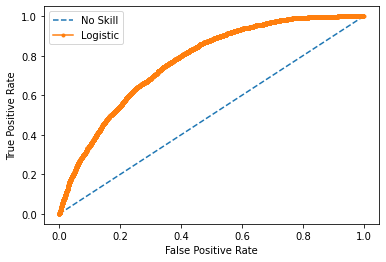

In [238]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(pred_result))]

# predict probabilities
lr_probs = pred_result

# keep probabilities for the positive outcome only
#lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test[target].values, ns_probs)
lr_auc = roc_auc_score(test[target].values, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.2f' % (ns_auc))
print('Logistic: ROC AUC=%.2f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test[target].values, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test[target].values, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Recommend Hotel for a user

In [190]:
rows = []
hotel = list(df.drop_duplicates(subset='item_id', keep='first').item_id)
names = list(df.drop_duplicates(subset='item_id', keep='first').item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'item_id' : hotel[i], 'user_id' : 1048}))
test_data = pd.DataFrame(rows)

In [191]:
for idx, (score, name) in enumerate(sorted(zip(pred_result, names), reverse=True)):
    if idx >= 5:
        break
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  0.33  for hotel cluster:  44
Score:  0.3  for hotel cluster:  9
Score:  0.29  for hotel cluster:  34
Score:  0.27  for hotel cluster:  1
Score:  0.26  for hotel cluster:  21


## Resources


https://github.com/shenweichen/DeepCTR

https://deepctr-doc.readthedocs.io/en/latest/deepctr.models.deepfm.html

https://github.com/shenweichen/DeepCTR/blob/ce140ffcc1057e8fb57622ae1732c39df32bc11e/docs/source/FAQ.md

https://github.com/shenweichen/DeepCTR/blob/db229dc31f0d4c79c0de2ece0bb919b35258d6b2/examples/run_regression_movielens.py

https://github.com/shenweichen/DeepCTR/blob/db229dc31f0d4c79c0de2ece0bb919b35258d6b2/examples/run_multivalue_movielens.py

https://deepctr-doc.readthedocs.io/en/latest/Examples.html#classification-criteo

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/